# Chapter 10: Quantifying effects and designing studies

In [2]:
library(tidyverse)
library(ggplot2)
library(cowplot)
library(boot)
library(MASS)
library(pwr)
set.seed(123456) # set random seed to exactly replicate results
theme_set(theme_minimal(base_size = 14))

library(knitr)

# load the NHANES data library
library(NHANES)

# drop duplicated IDs within the NHANES dataset
NHANES <-
  NHANES %>%
  dplyr::distinct(ID,.keep_all=TRUE)

NHANES_adult <-
  NHANES %>%
  drop_na(Weight) %>%
  subset(Age>=18)

## Figure 10.1

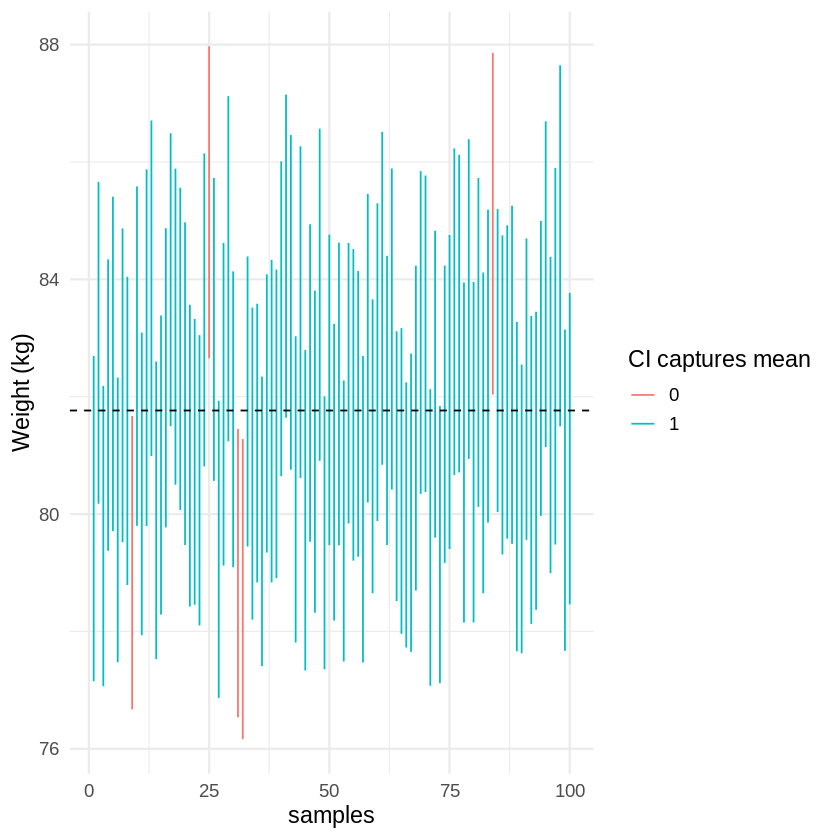

In [3]:
# take a sample from adults in NHANES and summarize their weight

sampSize <- 250
NHANES_sample <- sample_n(NHANES_adult, sampSize)

sample_summary <-
  NHANES_sample %>%
  summarize(
    meanWeight = mean(Weight),
    sdWeight = sd(Weight)
  )
# knitr(sample_summary,)

# compute confidence intervals for weight in NHANES data

sample_summary <-
  sample_summary %>%
  mutate(
    cutoff_lower = qt(0.025, sampSize),
    cutoff_upper = qt(0.975, sampSize),
    SEM = sdWeight / sqrt(sampSize),
    CI_lower = meanWeight + cutoff_lower * SEM,
    CI_upper = meanWeight + cutoff_upper * SEM
  )

set.seed(123456)
nsamples <- 100

sample_ci <- data.frame(run=0, lower=rep(0, nsamples), upper=rep(0, nsamples), captured=0)
for (i in 1:nsamples){
  sampSize <- 250
  NHANES_sample <- sample_n(NHANES_adult, sampSize)
  sample_summary <- NHANES_sample %>%
  summarize(
    meanWeight = mean(Weight),
    sdWeight = sd(Weight)
  ) %>%
  mutate(
    cutoff_lower = qt(0.025, sampSize),
    cutoff_upper = qt(0.975, sampSize),
    SEM = sdWeight / sqrt(sampSize),
    CI_lower = meanWeight + cutoff_lower * SEM,
    CI_upper = meanWeight + cutoff_upper * SEM
  )
  # does the CI capture the true mean
  captured = sample_summary['CI_lower'] < mean(NHANES_adult$Weight) & sample_summary['CI_upper'] > mean(NHANES_adult$Weight)
  sample_ci[i, ] = c(i, sample_summary[c('CI_lower', 'CI_upper')], captured)

}

# plot intervals
#sample_ci['captured'] = as.factor(sample_ci['captured'])
ggplot(sample_ci, aes(run, CI_lower)) +
  geom_segment(aes(x=run, xend=run, y=lower, yend=upper, color=as.factor(captured))) +
  geom_hline(yintercept=mean(NHANES_adult$Weight), linetype='dashed') +
  ylab('Weight (kg)') +
  xlab('samples') +
  labs(color = "CI captures mean")

## Figure 10.2

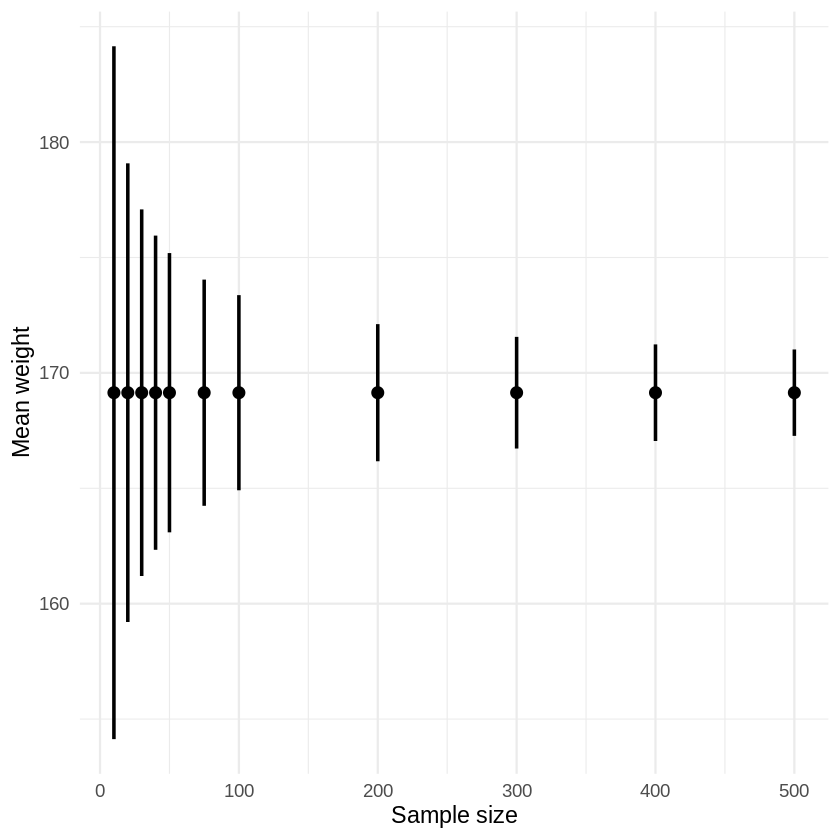

In [5]:
ssDf <-
  tibble(sampSize=c(10,20,30,40,50,75,100,200,300,400,500)) %>%
  mutate(
    meanHeight=mean(NHANES_sample$Height),
    ci.lower = meanHeight + qt(0.025,sampSize)*sd(NHANES_adult$Weight)/sqrt(sampSize),
    ci.upper = meanHeight + qt(0.975,sampSize)*sd(NHANES_adult$Weight)/sqrt(sampSize)
  )

ggplot(ssDf, aes(sampSize, meanHeight)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0, linewidth = 1) +
  labs(
    x = "Sample size",
    y = "Mean weight"
  )

Bootstrap confidence intervals

In [6]:
# compute bootstrap confidence intervals on NHANES weight data

meanWeight <- function(df, foo) {
  return(mean(df[foo, ]$Weight))
}

bs <- boot(NHANES_sample, meanWeight, 1000)

# use the percentile bootstrap
bootci <- boot.ci(bs, type = "perc")
print(bootci)

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = bs, type = "perc")

Intervals : 
Level     Percentile     
95%   (78.41, 83.81 )  
Calculations and Intervals on Original Scale


## Table 10.1

In [7]:
dInterp=tibble("D"=c('0.0 - 0.2',
                     '0.2 - 0.5',
                     '0.5 - 0.8',
                     '0.8 - '),
                   "Interpretation"=c('neglibible','small','medium','large')
                  )
kable(dInterp, caption="Interpetation of Cohen's D")



Table: Interpetation of Cohen's D

|D         |Interpretation |
|:---------|:--------------|
|0.0 - 0.2 |neglibible     |
|0.2 - 0.5 |small          |
|0.5 - 0.8 |medium         |
|0.8 -     |large          |

## Figure 10.3

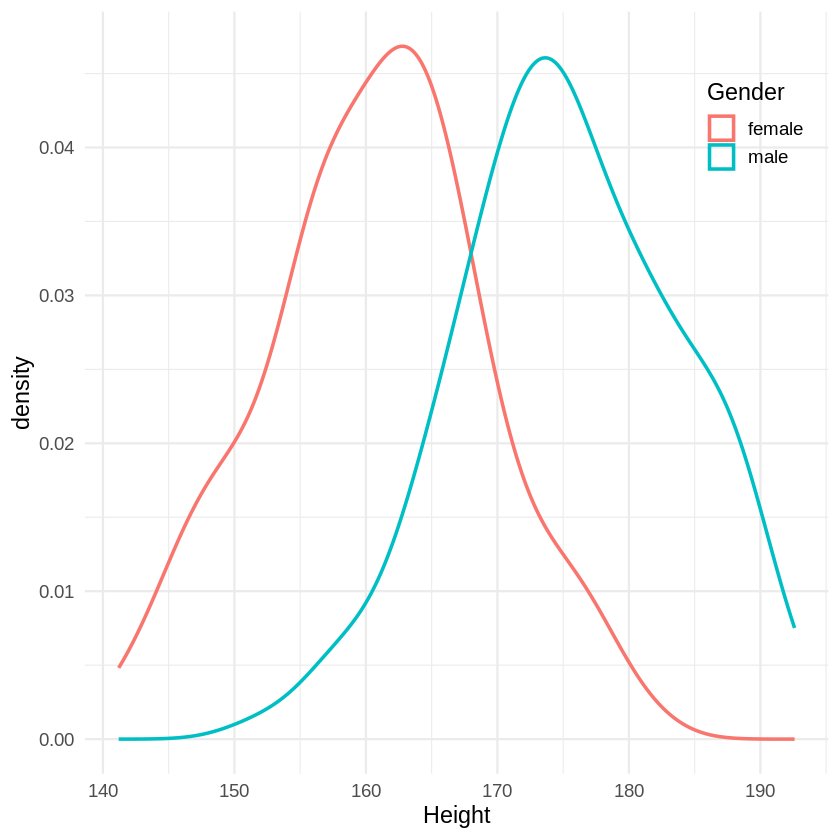

In [9]:
# compute effect size for gender difference in NHANES

NHANES_sample <-
  NHANES_adult %>%
  drop_na(Height) %>%
  sample_n(250)

hsum <-
  NHANES_sample %>%
  group_by(Gender) %>%
  summarize(
    meanHeight = mean(Height),
    varHeight = var(Height),
    n = n()
  )


#pooled SD
s_height_gender <- sqrt(
  ((hsum$n[1] - 1) * hsum$varHeight[1] + (hsum$n[2] - 1) * hsum$varHeight[2]) /
    (hsum$n[1] + hsum$n[2] - 2)
)

#cohen's d
d_height_gender <- (hsum$meanHeight[2] - hsum$meanHeight[1]) / s_height_gender

ggplot(NHANES_sample,aes(x=Height,color=Gender)) +
  geom_density(linewidth=1) +
  theme(legend.position = c(0.9,0.85))

## Figure 10.4

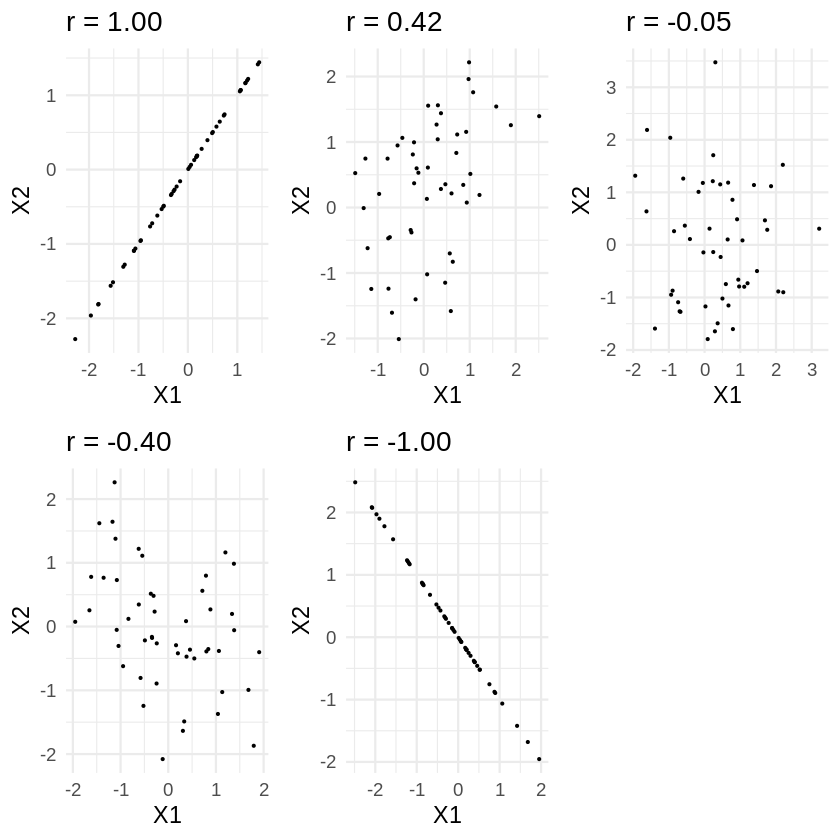

In [10]:
set.seed(123456789)
p <- list()
corrvals <- c(1,0.5,0,-0.5,-1)

for (i in 1:length(corrvals)){
  simdata <- data.frame(mvrnorm(n=50,mu=c(0,0),
                  Sigma=matrix(c(1,corrvals[i],corrvals[i],1),2,2))
                )
  tmp <- ggplot(simdata,aes(X1,X2)) +
    geom_point(size=0.5) +
    ggtitle(sprintf('r = %.02f',cor(simdata)[1,2]))
  p[[i]] = tmp
}
plot_grid(p[[1]],p[[2]],p[[3]],p[[4]],p[[5]])

## Table 10.2

In [11]:
# create table for cancer occurrence depending on smoking status
smokingDf <- tibble(
  Status = c("No Cancer", "Cancer"),
  NeverSmoked = c(2883, 220),
  CurrentSmoker = c(3829, 6784),
)
kable(smokingDf, caption="Lung cancer occurrence separately for current smokers and those who have never smoked")



Table: Lung cancer occurrence separately for current smokers and those who have never smoked

|Status    | NeverSmoked| CurrentSmoker|
|:---------|-----------:|-------------:|
|No Cancer |        2883|          3829|
|Cancer    |         220|          6784|

## Figure 10.5

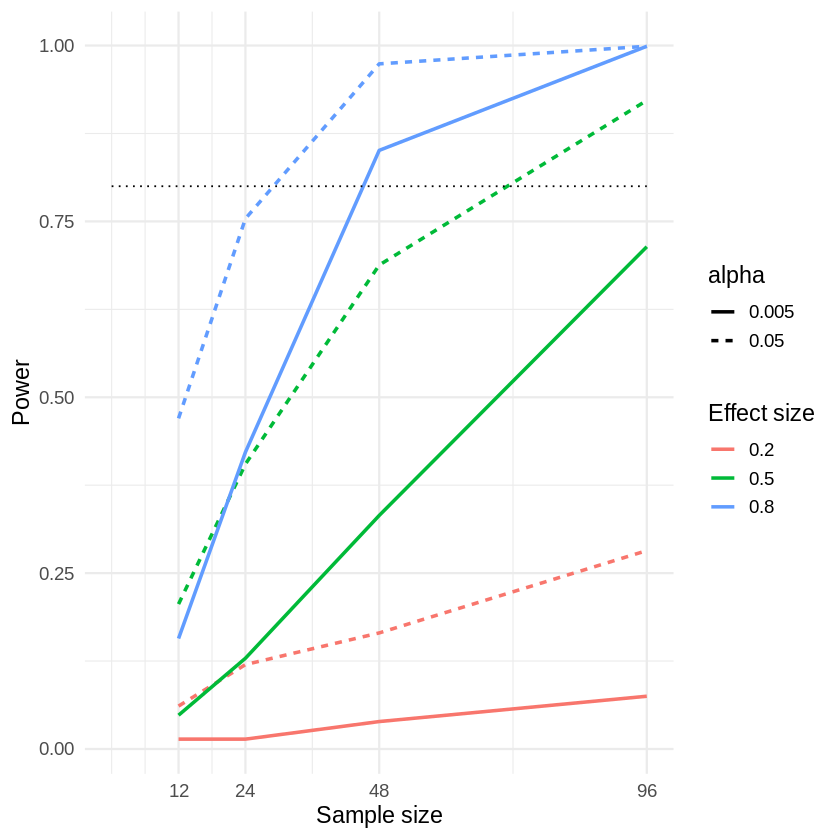

In [12]:
# Simulate power as a function of sample size, effect size, and alpha

# create a set of functions to generate simulated results
powerDf <-
  expand.grid(
    sampSizePerGroup = c(12, 24, 48, 96),
    effectSize = c(.2, .5, .8),
    alpha = c(0.005, 0.05)
  ) %>%
  tidyr::expand(effectSize, sampSizePerGroup, alpha) %>%
  group_by(effectSize, sampSizePerGroup, alpha)

runPowerSim <- function(df, nsims = 1000) {
  p <- array(NA, dim = nsims)
  for (s in 1:nsims) {
    data <- data.frame(
      y = rnorm(df$sampSizePerGroup * 2),
      group = array(0, dim = df$sampSizePerGroup * 2)
    )

    data$group[1:df$sampSizePerGroup] <- 1
    data$y[data$group == 1] <- data$y[data$group == 1] + df$effectSize
    tt <- t.test(y ~ group, data = data)
    p[s] <- tt$p.value
  }
  return(data.frame(power = mean(p < df$alpha)))
}

# run the simulation
powerSimResults <- powerDf %>%
  do(runPowerSim(.))

ggplot(powerSimResults,
       aes(sampSizePerGroup,power,color=as.factor(effectSize),linetype=as.factor(alpha))) +
  geom_line(size=1) +
  annotate('segment',x=0,xend=max(powerDf$sampSizePerGroup),
           y=0.8,yend=0.8,linetype='dotted',size=.5) +
  scale_x_continuous( breaks=unique(powerDf$sampSizePerGroup)) +
  labs(
    color = "Effect size",
    x = "Sample size",
    y = "Power",
    linetype = "alpha"
  )

## Power analyses

In [13]:
power.t.test(d = 0.5, power = 0.8, sig.level = 0.05)


     Two-sample t test power calculation 

              n = 63.76576
          delta = 0.5
             sd = 1
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


In [14]:
pwr.t.test(d = 2, power = 0.8, sig.level = 0.05)


     Two-sample t test power calculation 

              n = 5.089995
              d = 2
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group
